# SisFall Fall Detection — Model Training Notebook

This notebook trains a compact neural network for fall detection using the preprocessed SisFall windows saved as .npy files, optimized for later deployment on an ESP32 device. It loads the prepared datasets, verifies integrity and class balance, and sets up training utilities for a lightweight 1D-CNN suitable for real-time inference

## Step 1 — Setup and imports
This cell imports core libraries for loading NumPy arrays, building and training Keras models, computing metrics, and visualizing learning curves. It also sets a global random seed for reproducibility across runs, which is important when shuffling and initializing network weights 

In [1]:
#install necessary packages
%pip install numpy matplotlib pandas scikit-learn tensorflow keras

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 8.9 MB/s eta 0:00:38
   ---------------------------------------- 3.4/332.0 MB 10.4 MB/s eta 0:00:32
    --------------------------------------- 4.7/332.0 MB 10.3 MB/s eta 0:00:32
    --------------------------------------- 7.6/332.0 MB 10.3 MB/s eta 0:00:32
   - -------------------------------------- 10.0/332.0 MB 10.4 MB/s eta 0:00:31
   - -------------------------------------- 12.6/332.0 MB 10.6 MB/s eta 0:00:31
   - -------------------------------------- 14.9/332.0 MB 10.8 MB/s eta 0:00:30
   -- ------------------------------------- 17.6/332.0 MB 11.0 MB/s eta 0:00:29
   -- ------------------------------------- 18.6/332.0 MB 11.0 MB/s eta 0:00:29
   -- ------------------------------------- 22.5/332.0 MB 11.1 MB/s eta 0:00:28
   --- ------------------------------------ 25.2/332.0 MB 11.2 MB/s eta 0:00:28
   --- ------------------------------------ 27.8/332.0

In [2]:
# Step 1 — Setup and imports

import os, json, math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
OUTPUT_DIR = "./prepared_dataset_50hz"  # same as in the preparation notebook


c:\Users\Hp Pavilion 16\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Step 2 — Load datasets and manifest

This step loads the standardized windows and labels for Train/Val/TestA/TestB from the saved .npy files and reads the preprocessing manifest to capture parameters like channel means/stds, window size, and subject splits for traceability and inference alignment on-device

In [3]:
# Step 2 — Load datasets and manifest

# Load arrays
X_train = np.load(os.path.join(OUTPUT_DIR, "X_train.npy"))
y_train = np.load(os.path.join(OUTPUT_DIR, "y_train.npy"))
X_val   = np.load(os.path.join(OUTPUT_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(OUTPUT_DIR, "y_val.npy"))
X_testA = np.load(os.path.join(OUTPUT_DIR, "X_testA.npy"))
y_testA = np.load(os.path.join(OUTPUT_DIR, "y_testA.npy"))
X_testB = np.load(os.path.join(OUTPUT_DIR, "X_testB.npy"))
y_testB = np.load(os.path.join(OUTPUT_DIR, "y_testB.npy"))

# Load manifest
with open(os.path.join(OUTPUT_DIR, "preprocessing_manifest.json"), "r") as f:
    manifest = json.load(f)

print("Loaded shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("TestA:", X_testA.shape, y_testA.shape)
print("TestB:", X_testB.shape, y_testB.shape)

print("\nChannels:", manifest["channels"])
print("Window size:", manifest["window_size"], "Step:", manifest["step"])
print("Standardization mean:", manifest["channel_mean"])
print("Standardization std :", manifest["channel_std"])


Loaded shapes:
Train: (91249, 50, 4) (91249,)
Val  : (15099, 50, 4) (15099,)
TestA: (10169, 50, 4) (10169,)
TestB: (37554, 50, 4) (37554,)

Channels: ['Ax_g', 'Ay_g', 'Az_g', 'A_mag_g']
Window size: 50 Step: 25
Standardization mean: [-0.011028575710952282, -0.6575165390968323, -0.08011220395565033, 1.044303059577942]
Standardization std : [0.4364461898803711, 0.6011266112327576, 0.4885464608669281, 0.37257862091064453]


## Step 3 — Quick integrity checks and class balance

This cell verifies that labels contain only {0,1}, prints class distributions for each split, and optionally plots a few random windows to visually confirm signal quality matches expectations from the preparation notebook (smooth, standardized, clear |A| dynamics)

In [4]:
# Step 3 — Integrity checks and balance

def summarize_split(name, y):
    total = int(y.shape[0])
    falls = int((y == 1).sum())
    adl   = total - falls
    pf = 100.0 * falls / total if total else 0.0
    pa = 100.0 * adl   / total if total else 0.0
    print(f"{name}: total={total}, falls={falls} ({pf:.2f}%), non-fall={adl} ({pa:.2f}%)")

# Label checks
for name, y in [("Train", y_train), ("Val", y_val), ("TestA", y_testA), ("TestB", y_testB)]:
    assert set(np.unique(y)).issubset({0,1}), f"Unexpected labels in {name}: {np.unique(y)}"

# Summaries
summarize_split("Train", y_train)
summarize_split("Val",   y_val)
summarize_split("TestA", y_testA)
summarize_split("TestB", y_testB)

# Optional: visualize a random window from train to confirm scaling and magnitude behavior
rng = np.random.default_rng(SEED)

def plot_random(X, y, title):
    if X.shape[0] == 0:
        print(f"No samples in {title}")
        return
    idx = rng.integers(0, X.shape[0])
    t = np.arange(X.shape[1]) / manifest["fs_out"]
    plt.figure(figsize=(9,4))
    plt.plot(t, X[idx,:,0], label="Ax")
    plt.plot(t, X[idx,:,1], label="Ay")
    plt.plot(t, X[idx,:,2], label="Az")
    plt.plot(t, X[idx,:,3], label="|A|")
    plt.title(f"{title} (label={y[idx]})")
    plt.xlabel("Time (s)")
    plt.ylabel("Standardized units")
    plt.legend()
    plt.tight_layout()
    plt.show()


Train: total=91249, falls=39146 (42.90%), non-fall=52103 (57.10%)
Val: total=15099, falls=6467 (42.83%), non-fall=8632 (57.17%)
TestA: total=10169, falls=4348 (42.76%), non-fall=5821 (57.24%)
TestB: total=37554, falls=2175 (5.79%), non-fall=35379 (94.21%)


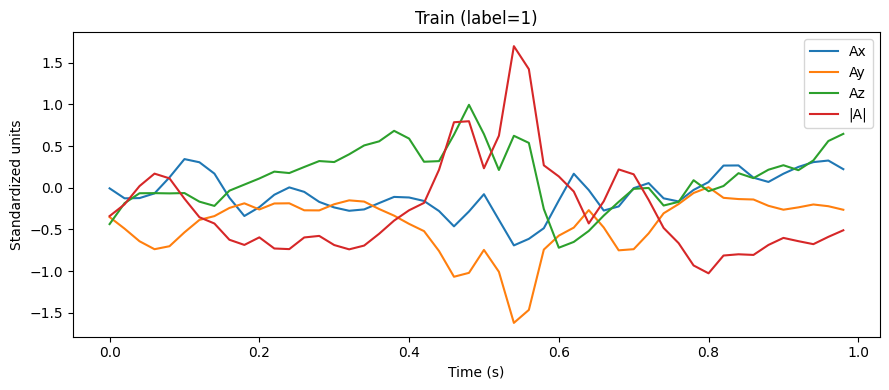

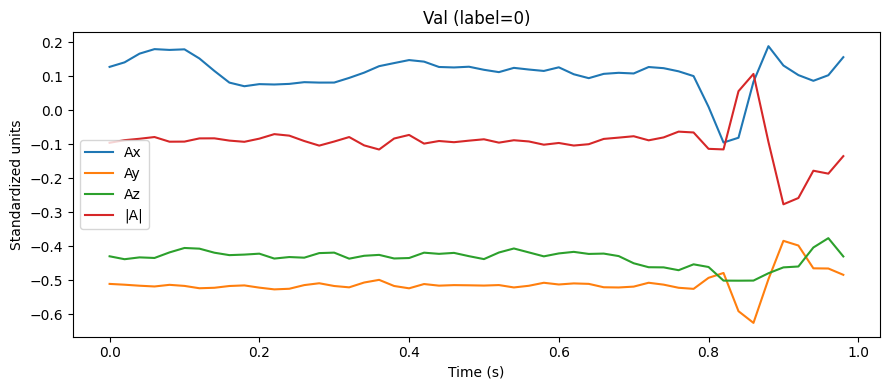

In [5]:
# Uncomment to preview
plot_random(X_train, y_train, "Train")
plot_random(X_val,   y_val,   "Val")

### Step 4 — Prepare tensors and class weights

This step reshapes inputs for Keras, computes class weights to counter mild imbalance in Train (≈43% falls vs. 57% non‑falls), and builds tf.data pipelines for efficient shuffling and batching. Class weighting helps the model give sufficient attention to the rarer fall class during optimization without duplicating data.


In [6]:
# Step 4 — Prepare tensors and class weights

# Keras expects (N, T, C); no extra channel axis needed for Conv1D. Keep as-is.
T = X_train.shape[1]
C = X_train.shape[2]

# Compute class weights from Train labels
num_pos = int((y_train == 1).sum())
num_neg = int((y_train == 0).sum())
total   = num_pos + num_neg
# Balanced heuristic: total / (num_classes * count_c)
class_weight = {
    0: total / (2.0 * num_neg),
    1: total / (2.0 * num_pos)
}
print("Class weights:", class_weight)

BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(X), 10000), seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(X_train, y_train, training=True)
ds_val   = make_ds(X_val,   y_val,   training=False)
ds_testA = make_ds(X_testA, y_testA, training=False)
ds_testB = make_ds(X_testB, y_testB, training=False)


Class weights: {0: 0.8756597508780685, 1: 1.165495836100751}


### Step 5 — Define a compact 1D‑CNN

A lightweight 1D‑CNN captures short temporal patterns (impacts, transients) across the 4 channels while staying small enough for ESP32 deployment after TFLite quantization. Two convolution blocks with pooling reduce temporal size, followed by a small dense head for binary classification.


In [7]:
# Step 5 — Define a compact 1D‑CNN

def build_model(input_shape):
    inputs = keras.Input(shape=input_shape)  # (50, 4)

    x = layers.Conv1D(32, kernel_size=3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)  # -> (25, 32)

    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # -> (12, 64)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="cnn_fall_1d_compact")
    return model

model = build_model((T, C))
model.summary()


Model: "cnn_fall_1d_compact"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,361 (138.13 KB)

 Trainable params: 35,361 (138.13 KB)

 Non-trainable params: 0 (0.00 B)

### Step 6 — Compile training (loss, optimizer, metrics, callbacks)

Use binary cross‑entropy for the fall/not‑fall task, Adam optimizer for stable convergence, and track precision/recall/F1 via a custom callback or by computing them after each epoch. Early stopping and learning‑rate reduction help avoid overfitting and speed training on this relatively small model.


In [8]:
# Step 6 — Compile training configuration

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint("best_cnn_fall.keras", monitor="val_loss", save_best_only=True),
]


### Step 7 — Train the model

Train the compact 1D‑CNN using class weights to counter mild imbalance. Early stopping and learning‑rate reduction limit overfitting and speed convergence. Monitor accuracy, precision, and recall on the validation set; aim for high recall on falls.


In [9]:
# Step 7 — Train the model

EPOCHS = 40

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# Save final weights alongside the best checkpoint
model.save("final_cnn_fall.keras")


Epoch 1/40
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7920 - loss: 0.4621 - precision: 0.7942 - recall: 0.6952 - val_accuracy: 0.7451 - val_loss: 0.5430 - val_precision: 0.6730 - val_recall: 0.7878 - learning_rate: 0.0010
Epoch 2/40
713/713 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8144 - loss: 0.4146 - precision: 0.7947 - recall: 0.7650 - val_accuracy: 0.7813 - val_loss: 0.4983 - val_precision: 0.7240 - val_recall: 0.7909 - learning_rate: 0.0010
Epoch 3/40
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8273 - loss: 0.3871 - precision: 0.8055 - recall: 0.7875 - val_accuracy: 0.7408 - val_loss: 0.5180 - val_precision: 0.6591 - val_recall: 0.8175 - learning_rate: 0.0010
Epoch 4/40
713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8339 - loss: 0.3711 - precision: 0.8091 - recall: 0.8021 - val_accuracy: 0.7111 - val_loss: 0.5871 - val_precision: 0.6214 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 5/40
713/713 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc

### Step 8 — Evaluate on TestA and TestB

Compute threshold‑free metrics (AUC) and thresholded metrics (accuracy, precision, recall, F1) separately for TestA (adult holdout) and TestB (elderly). Start with a default threshold of 0.5, then sweep thresholds to see the precision‑recall trade‑off and choose an operating point that prioritizes fall recall.


In [10]:
# Step 8 — Evaluate on TestA and TestB

def evaluate_split(X, y, name, thresh=0.5):
    probs = model.predict(X, batch_size=256).reshape(-1)
    preds = (probs >= thresh).astype(int)
    print(f"\n{name} @ threshold={thresh:.2f}")
    print(classification_report(y, preds, digits=3))
    cm = confusion_matrix(y, preds)
    print("Confusion matrix:\n", cm)

    # Precision-Recall AUC
    p, r, t = precision_recall_curve(y, probs)
    pr_auc = auc(r, p)
    print(f"PR AUC: {pr_auc:.3f}")
    return probs, (p, r, t), pr_auc

probs_A, pr_A, auc_A = evaluate_split(X_testA, y_testA, "TestA", thresh=0.5)
probs_B, pr_B, auc_B = evaluate_split(X_testB, y_testB, "TestB", thresh=0.5)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

TestA @ threshold=0.50
              precision    recall  f1-score   support

           0      0.801     0.702     0.748      5821
           1      0.658     0.767     0.708      4348

    accuracy                          0.730     10169
   macro avg      0.730     0.735     0.728     10169
weighted avg      0.740     0.730     0.731     10169

Confusion matrix:
 [[4087 1734]
 [1013 3335]]
PR AUC: 0.784
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

TestB @ threshold=0.50
              precision    recall  f1-score   support

           0      0.984     0.579     0.729     35379
           1      0.110     0.843     0.194      2175

    accuracy                          0.594     37554
   macro avg      0.547     0.711     0.461     37554
weighted avg      0.933     0.594     0.698     37554

Confusion matrix:
 [[20473 14906]
 [  342  1833]]
PR AUC: 0.402


### Step 9 — Tune the decision threshold

Select a threshold that achieves the desired balance (e.g., maximize F1 on validation, or enforce a minimum fall recall while keeping false positives acceptable). Use the validation set for selection, then report metrics on TestA and TestB at the chosen threshold.


In [11]:
# Step 9 — Tune the decision threshold on validation

val_probs = model.predict(X_val, batch_size=256).reshape(-1)

def find_best_threshold(y_true, y_prob, target="f1"):
    p, r, t = precision_recall_curve(y_true, y_prob)
    f1 = (2 * p * r) / (p + r + 1e-9)
    if target == "f1":
        idx = np.nanargmax(f1)
    elif target == "recall_at_precision":  # example: recall where precision >= 0.8
        mask = p >= 0.8
        idx = np.argmax(r * mask)
    else:
        idx = np.nanargmax(f1)
    best = {
        "threshold": t[max(idx-1,0)] if len(t) > 0 else 0.5,
        "precision": float(p[idx]),
        "recall":    float(r[idx]),
        "f1":        float(f1[idx]),
    }
    return best

best = find_best_threshold(y_val, val_probs, target="f1")
print("Best threshold on Val:", best)

# Re-evaluate TestA/TestB at chosen threshold
_ = evaluate_split(X_testA, y_testA, "TestA (tuned)", thresh=best["threshold"])
_ = evaluate_split(X_testB, y_testB, "TestB (tuned)", thresh=best["threshold"])


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold on Val: {'threshold': np.float32(0.69949657), 'precision': 0.8074098798397864, 'recall': 0.7481057677439307, 'f1': 0.7766273371682763}
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

TestA (tuned) @ threshold=0.70
              precision    recall  f1-score   support

           0      0.768     0.861     0.812      5821
           1      0.778     0.652     0.710      4348

    accuracy                          0.772     10169
   macro avg      0.773     0.757     0.761     10169
weighted avg      0.772     0.772     0.768     10169

Confusion matrix:
 [[5010  811]
 [1511 2837]]
PR AUC: 0.784
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

TestB (tuned) @ threshold=0.70
              precision    recall  f1-score   support

           0      0.983     0.759     0.857     35379
           1      0.168     0.791     0.277      2175

    accuracy                          0.761     37554
   macro avg      0.576     0.775     0.567     37554
weighted

## Export and Validate TFLite Model (Deployment-Ready)

This section converts the best Keras model to TensorFlow Lite (both float and int8‑quantized), checks that quantization preserves performance, and writes a small deployment config (threshold and smoothing) alongside the preprocessing manifest. The int8 model is preferred for ESP32 due to speed and memory footprint.

What you’ll get:
- best_cnn_fall.tflite (float)
- best_cnn_fall_int8.tflite (int8)
- deploy_config.json (threshold, smoothing, channel stats, window params)

We validate parity by running TFLite inference on the validation set and comparing precision/recall at the tuned threshold (≈0.65).


## Step 10 — Export Keras → TFLite (float & int8)

Convert the best validation model to TFLite. Create both a float model and an int8‑quantized model (dynamic range) for ESP32. Report file sizes.


In [12]:
import os, json
import numpy as np
import tensorflow as tf
from tensorflow import keras

BEST_MODEL_PATH = "best_cnn_fall.keras"

# Load best model (restored by EarlyStopping)
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Float TFLite
conv_float = tf.lite.TFLiteConverter.from_keras_model(best_model)
tfl_float_bytes = conv_float.convert()
with open("best_cnn_fall.tflite", "wb") as f:
    f.write(tfl_float_bytes)

# Int8 dynamic-range quantization
conv_int8 = tf.lite.TFLiteConverter.from_keras_model(best_model)
conv_int8.optimizations = [tf.lite.Optimize.DEFAULT]
tfl_int8_bytes = conv_int8.convert()
with open("best_cnn_fall_int8.tflite", "wb") as f:
    f.write(tfl_int8_bytes)

print("TFLite float size (KB):", os.path.getsize("best_cnn_fall.tflite")/1024)
print("TFLite int8  size (KB):", os.path.getsize("best_cnn_fall_int8.tflite")/1024)


INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmpmaemgsyr\assets


INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmpmaemgsyr\assets


Saved artifact at 'C:\Users\HPPAVI~1\AppData\Local\Temp\tmpmaemgsyr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2488426898512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426904272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426892176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426902928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426896400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426905424: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmpepen8pr3\assets


INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmpepen8pr3\assets


Saved artifact at 'C:\Users\HPPAVI~1\AppData\Local\Temp\tmpepen8pr3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2488426898512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426904272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426892176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426902928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426896400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426905424: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite float size (KB): 144.5390625
TFLite int8  size (KB): 43.6875


## Step 11 — Validate TFLite parity on Val set

Some TFLite models are fixed to batch=1. Use a per‑sample prediction loop to avoid “dimension mismatch” errors. Compare Keras vs. TFLite (float & int8) precision/recall at the tuned threshold (≈0.65).


In [13]:
from sklearn.metrics import classification_report

# Load validation data and manifest
OUTPUT_DIR = "./prepared_dataset_50hz"
X_val = np.load(os.path.join(OUTPUT_DIR, "X_val.npy"))
y_val = np.load(os.path.join(OUTPUT_DIR, "y_val.npy"))

THRESH = 0.65  # tuned on validation

# Keras baseline
probs_keras = best_model.predict(X_val, batch_size=256).reshape(-1)
preds_keras = (probs_keras >= THRESH).astype(int)

# TFLite single-window predictor (handles batch=1 models)
def tflite_predict_single(tflite_bytes, X):
    interpreter = tf.lite.Interpreter(model_content=tflite_bytes)
    interpreter.allocate_tensors()
    in_details  = interpreter.get_input_details()[0]
    out_details = interpreter.get_output_details()[0]

    # Confirm input expects batch=1
    in_shape = in_details["shape"]
    # Typical shape: [1, 50, 4]
    preds = []
    for i in range(len(X)):
        xb = X[i:i+1].astype(np.float32)  # (1, 50, 4)
        interpreter.set_tensor(in_details["index"], xb)
        interpreter.invoke()
        yb = interpreter.get_tensor(out_details["index"]).reshape(-1)
        preds.append(yb[0])
    return np.array(preds)

# Load TFLite bytes
with open("best_cnn_fall.tflite", "rb") as f:
    tfl_float_bytes = f.read()
with open("best_cnn_fall_int8.tflite", "rb") as f:
    tfl_int8_bytes = f.read()

# Predict
probs_float = tflite_predict_single(tfl_float_bytes, X_val)
probs_int8  = tflite_predict_single(tfl_int8_bytes,  X_val)

preds_float = (probs_float >= THRESH).astype(int)
preds_int8  = (probs_int8  >= THRESH).astype(int)

print("\nKeras @ Val")
print(classification_report(y_val, preds_keras, digits=3))
print("\nTFLite float @ Val")
print(classification_report(y_val, preds_float, digits=3))
print("\nTFLite int8 @ Val")
print(classification_report(y_val, preds_int8, digits=3))


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Hp Pavilion 16\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



Keras @ Val
              precision    recall  f1-score   support

           0      0.825     0.847     0.836      8632
           1      0.788     0.761     0.774      6467

    accuracy                          0.810     15099
   macro avg      0.807     0.804     0.805     15099
weighted avg      0.809     0.810     0.810     15099


TFLite float @ Val
              precision    recall  f1-score   support

           0      0.825     0.847     0.836      8632
           1      0.788     0.761     0.774      6467

    accuracy                          0.810     15099
   macro avg      0.807     0.804     0.805     15099
weighted avg      0.809     0.810     0.810     15099


TFLite int8 @ Val
              precision    recall  f1-score   support

           0      0.826     0.848     0.837      8632
           1      0.790     0.761     0.775      6467

    accuracy                          0.811     15099
   macro avg      0.808     0.805     0.806     15099
weighted avg      0.81

## Step 12 — Write deployment config (threshold + smoothing + manifest merge)

Bundle the tuned threshold, simple temporal smoothing, and preprocessing stats into a single JSON alongside the TFLite files. Firmware will read this to standardize inputs and apply decision logic.


In [14]:
# Merge preprocessing manifest with deployment settings
with open(os.path.join(OUTPUT_DIR, "preprocessing_manifest.json"), "r") as f:
    prep = json.load(f)

deploy_cfg = {
    "model": {
        "filename_int8": "best_cnn_fall_int8.tflite",
        "input_shape": [prep["window_size"], len(prep["channels"])],  # [50,4]
        "threshold": THRESH
    },
    "preprocessing": {
        "fs_out": prep["fs_out"],
        "window_size": prep["window_size"],
        "step": prep["step"],
        "channels": prep["channels"],
        "channel_mean": prep["channel_mean"],
        "channel_std": prep["channel_std"]
    },
    "postprocessing": {
        "confirm_windows": 2,     # require 2 consecutive positives
        "refractory_windows": 2   # wait 2 windows after trigger
    }
}

with open("deploy_config.json", "w") as f:
    json.dump(deploy_cfg, f, indent=2)

print("Wrote deploy_config.json with threshold and smoothing.")


Wrote deploy_config.json with threshold and smoothing.


## (Optional) Step 13 — Full integer quantization with calibration

If int8 parity drifts, supply a small calibration dataset (random train batches) to enable full integer quantization.


In [15]:
# Optional: Full integer quantization (uses calibration data)
def representative_dataset_gen():
    # sample ~100 batches of 1 window from training set for calibration
    X_train = np.load(os.path.join(OUTPUT_DIR, "X_train.npy"))
    for i in range(100):
        idx = np.random.randint(0, len(X_train))
        sample = X_train[idx:idx+1].astype(np.float32)  # (1, 50, 4)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
# Try full int8 inference on supported kernels
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
                                       tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tfl_int8_full = converter.convert()
    with open("best_cnn_fall_int8_full.tflite", "wb") as f:
        f.write(tfl_int8_full)
    print("Wrote best_cnn_fall_int8_full.tflite")
except Exception as e:
    print("Full int8 conversion fell back or failed:", e)


INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmp49wx01mw\assets


INFO:tensorflow:Assets written to: C:\Users\HPPAVI~1\AppData\Local\Temp\tmp49wx01mw\assets


Saved artifact at 'C:\Users\HPPAVI~1\AppData\Local\Temp\tmp49wx01mw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2488426898512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426895248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426904272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426892176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426902928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426896400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2488426905424: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\Hp Pavilion 16\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Wrote best_cnn_fall_int8_full.tflite


## Deployment checklist

- Files to copy to firmware: `best_cnn_fall_int8.tflite` (or `_full`), `deploy_config.json`.  
- On-device: 50 Hz read → |A| → standardize with means/stds → 1 s buffer (50×4) → TFLite Micro inference → compare to threshold (0.65) → confirm 2 consecutive positives → vibrate/log and start refractory window.  
- Validate in the field: adjust `confirm_windows` and threshold if needed to balance elderly false alarms vs. fall recall.


In [16]:
# Step 10 — Generate C++ Header for Arduino
# ---------------------------------------------------------
import os

def hex_to_c_array(tflite_path, output_header_path, array_name="g_model"):
    # Read the .tflite file
    with open(tflite_path, "rb") as f:
        tflite_content = f.read()

    # Convert to hex bytes
    hex_array = ", ".join([f"0x{b:02x}" for b in tflite_content])

    # Create C++ code
    c_code = f"""
// Auto-generated TensorFlow Lite Micro model
// Source: {tflite_path}
// Copy this content into a file named 'model.h' in your Arduino project

#ifndef MODEL_H
#define MODEL_H

#include <stdint.h>

// Model size: {len(tflite_content)} bytes
const unsigned int {array_name}_len = {len(tflite_content)};
const unsigned char {array_name}[] = {{
  {hex_array}
}};

#endif // MODEL_H
"""

    # Save to file
    with open(output_header_path, "w") as f:
        f.write(c_code)
    print(f"✅ Success! C++ header saved to: {output_header_path}")

# Run the conversion
# We use the Full Int8 model (best for ESP32 speed) if available, otherwise the standard Int8
if os.path.exists("best_cnn_fall_int8_full.tflite"):
    target_model = "best_cnn_fall_int8_full.tflite"
elif os.path.exists("best_cnn_fall_int8.tflite"):
    target_model = "best_cnn_fall_int8.tflite"
else:
    target_model = None

if target_model is None:
    print("❌ No TFLite file found. Expected 'best_cnn_fall_int8_full.tflite' or 'best_cnn_fall_int8.tflite'.")
else:
    hex_to_c_array(target_model, "model.h")


✅ Success! C++ header saved to: model.h
